In [1]:
from trikde.pdfs import DensitySamples, IndepdendentLikelihoods, CustomPriorHyperCube
import os
from lenslikelihood.measurements import flux_measurements, flux_measurement_uncertainties, all_lens_names, all_param_ranges
import pickle

import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt


## Folding new priors into the inference

This notebook demonstrates how to fold in new priors on various hyper-parameters. We'll consider two different priors:

1) a prior on the normalization and slope of the subhalo mass function inferred from stellar streams

2) a prior on the concentration-mass relation based on observations of dwarf galaxies 

First, we will load the pre-computed lensing-only likelihoods. These can be computed and saved for later use with the notebook "inference_5D_from_scatch". 

In [2]:
from lenslikelihood.measurements import flux_measurements, flux_measurement_uncertainties, all_lens_names, all_param_ranges_version2
import numpy as np


nbins = 20
# Note that the syntax for the uncertainties is
# {'lens_name': (1-sigma-uncertainty, reference_index, uncertainty_in_ratio)}
# where reference_index is the reference image with which to compute the flux ratio, and uncertainty_in_ratio specifies
# whether the measurement uncertainty refers to the flux or the flux ratio
param_names = ['LOS_normalization', 'beta', 'log10c0', 'delta_power_law_index', 'sigma_sub']
param_ranges = [all_param_ranges_version2[name] for name in param_names]
print(param_ranges)
nbins = 20
likelihoods = []

filename_extension = '_joint_logprior'
base_path = './../lenslikelihood/precomputed_likelihoods/'
print(all_lens_names)

lens_list = ['B1422',
            'HE0435',
            'WGD2038',
            'WGDJ0405',
            'WFI2033',
            'PSJ1606',
            'WFI2026',
            'RXJ0911',
            'RXJ1131',
            'MG0414',
            'PG1115']

for lens in lens_list:
    
    fname = base_path + lens + filename_extension
    print('loading joint likelihoods for lens '+lens+' ...')
    f = open(fname, 'rb')
    single_lens_likelihood = pickle.load(f)
    f.close()
    likelihoods.append(single_lens_likelihood)
    
likelihood_nprior = IndepdendentLikelihoods(likelihoods)

[[0.0, 2.5], [-0.2, 15.0], [0, 4], [-0.6, 0.9], [0, 0.125]]
['HE0435', 'WGD2038', 'B1422', 'WFI2033', 'PSJ1606', 'WFI2026', 'RXJ0911', 'MG0414', 'PG1115', 'RXJ1131', 'WGDJ0405']
loading joint likelihoods for lens B1422 ...
loading joint likelihoods for lens HE0435 ...
loading joint likelihoods for lens WGD2038 ...
loading joint likelihoods for lens WGDJ0405 ...
loading joint likelihoods for lens WFI2033 ...
loading joint likelihoods for lens PSJ1606 ...
loading joint likelihoods for lens WFI2026 ...
loading joint likelihoods for lens RXJ0911 ...
loading joint likelihoods for lens RXJ1131 ...
loading joint likelihoods for lens MG0414 ...
loading joint likelihoods for lens PG1115 ...


### Custom priors and importance weights

To priors or importance weights, we can use a CustomPriorHyperCube object. This class takes as input a function that computes a chi2 for each sample, given the full array of samples in the likelihood. As an example, we'll use this to enforce a prior on the normalization of the concentration-mass relation

In [3]:
def prior_function_mc_relation(samples, log10_c8_mean=np.log10(18.), delta_log10_c8=0.25, beta_mean=0.8, delta_beta=0.2):
    
    log10c8_samples = samples[:, 2]
    beta_samples = samples[:,1]
    chi2 = (log10c8_samples - log10_c8_mean)**2/delta_log10_c8**2 
    chi2 += (beta_samples - beta_mean)**2/delta_beta**2
    return chi2

def prior_function_coupled_mass_functions(samples, sigma_sub_mean_cdm=0.05, coupling=0.2):
    """
    correlated line of sight and subhalo mass function amplitudes
    """
    los_norm_samples = samples[:, 0]
    sigma_sub_samples = samples[:, -1]
    delta_sigma_sub = sigma_sub_samples/sigma_sub_mean_cdm
    chi2 = (los_norm_samples - delta_sigma_sub)**2/coupling**2 
    return chi2

prior_on_mc_relation = CustomPriorHyperCube(prior_function_mc_relation, param_names, param_ranges, nbins)
prior_on_mass_functions = CustomPriorHyperCube(prior_function_coupled_mass_functions, param_names, param_ranges, nbins)

likelihood_with_prior_1 = IndepdendentLikelihoods(likelihoods + [prior_on_mc_relation])
likelihood_with_prior_2 = IndepdendentLikelihoods(likelihoods + [prior_on_mass_functions])
likelihood_with_prior_3 = IndepdendentLikelihoods(likelihoods + [prior_on_mc_relation, prior_on_mass_functions])

/Users/danielgilman/.local/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


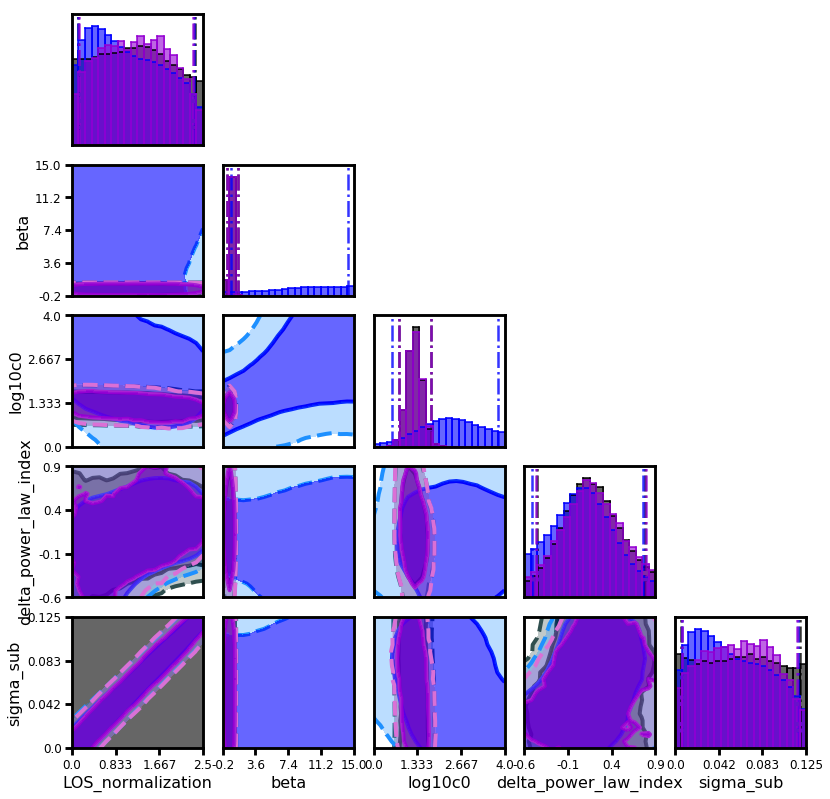

In [4]:
from trikde.triangleplot import TrianglePlot

triangle_plot = TrianglePlot([likelihood_with_prior_1, likelihood_with_prior_2, likelihood_with_prior_3])
axes = triangle_plot.make_triplot(filled_contours=True, show_intervals=True, show_contours=True)

### Sampling the likelihood

In [5]:
from lenslikelihood.sampling import InterpolatedLikelihood

interpolated_likelihood = InterpolatedLikelihood(likelihood_with_prior_3, param_names, param_ranges)

# we can save time by only sampling from regions of parameter space with significant likelihood, 
# given the priors we added
reduced_sampling_ranges = [[0.0, 2.5], [0.8 - 0.6, 0.8 + 0.6], [0, 2], [-0.6, 0.9], [0, 0.125]]
n_samples = 500
samples_from_pdf = interpolated_likelihood.sample(n_samples, pranges=reduced_sampling_ranges)

sampling.... 10.0%
sampling.... 20.0%
sampling.... 30.0%
sampling.... 40.0%
sampling.... 50.0%
sampling.... 60.0%
sampling.... 70.0%
sampling.... 80.0%
sampling.... 90.0%


(array([25., 30., 45., 63., 76., 85., 67., 49., 32., 28.]),
 array([-0.6 , -0.45, -0.3 , -0.15,  0.  ,  0.15,  0.3 ,  0.45,  0.6 ,
         0.75,  0.9 ]),
 <a list of 10 Patch objects>)

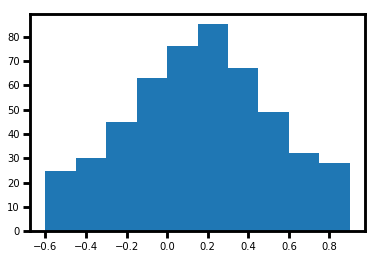

In [8]:
delta_plaw_index = samples_from_pdf[:, 3]
plt.hist(delta_plaw_index, range=(-0.6, 0.9), bins=10)